In [1]:
import utils.file_utils as fu
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import yaml
from scipy.signal import argrelextrema
import numpy as np
import seaborn as sns


In [2]:
def add_strike_lift(df,correction=True,smooth=True):
    fy=df.copy()
    fy=df.filter(like="Fy",axis=1)
    try:
        fy.columns=['left','right']
    except:
        print(df)
        return None
    smooth_size=10
    offset_lift=0
    offset_strike=0
    if smooth:
        offset_strike=smooth_size
        r=fy.rolling(smooth_size) #smooting (sum with 10 neighbours)
        fy=r.sum()  
    n=50 # number of points to be checked before and after 
    left_swing = argrelextrema(fy.left.values, np.less_equal, order=n)
    s=left_swing[0]
    offset_lift=0
    offset_strike=0
    
    s_filter=[s[idx+1]-offset_lift for idx in range(len(s)-1) if s[idx+1]-s[idx]>10 ]
    #s_filter.append(s[0])
    #s_filter=[s[idx]-offset_lift for idx in range(len(s)-1) if s[idx+1]-s[idx]>10 ]
    fy['l_lift']=fy.iloc[s_filter]['left']
    fy['l_off']=fy.iloc[s]['left']
    
    s_filter=[s[idx] for idx in range(len(s)-1) if s[idx+1]-s[idx]>10 ]
    fy["l_strike"]=fy.iloc[s_filter]['left']
    
    
    
    right_swing=argrelextrema(fy.right.values, np.less_equal, order=n)#[0]['right']
    s=right_swing[0]
    s_filter=[s[idx+1] for idx in range(len(s)-1) if s[idx+1]-s[idx]>10 ]
    fy['r_lift']=fy.iloc[s_filter]['right']
    fy['r_off']=fy.iloc[s]['right']
    s_filter=[s[idx] for idx in range(len(s)-1) if s[idx+1]-s[idx]>10 ]
    fy["r_strike"]=fy.iloc[s_filter]['right']
    
    #fy['r_strike'] = fy.iloc[argrelextrema(fy.right.values, np.greater_equal, order=n)[0]-smooth_size]['right']
    #fy['l_strike'] = fy.iloc[argrelextrema(fy.left.values, np.greater_equal, order=n)[0]-smooth_size]['left']
    
    
    if correction:
        return fp_correction(fy)
    else:
        return fy

In [3]:
def fp_correction(fy_df,what="strike"):
    corr_df=fy_df.copy()
    idx_lift=fy_df[fy_df.l_lift.notnull()].index.to_list()
    idx_strike=fy_df[fy_df.l_strike.notnull()].index.to_list()
    #print(idx_lift)
    #print(idx_strike)
    if what=="strike":
        """
        Checks that there is only one strike before the next lift detection.
        If there is two, only consider the first one
        """
        for n in range(len(idx_strike)-1):
            if n>=len(idx_strike)-1:
                print("Breaking")
                break
            else:
                c_strike=idx_strike[n]
                n_strike=idx_strike[n+1]
                c_lift=idx_lift[n]
                #print("C_strike",c_strike,"n_strike",n_strike,"c_lift",c_lift,"\n")
                if n_strike<c_lift:
                    strike=idx_strike.pop(n+1)
                    print("Removing strike",strike)
                    corr_df.l_strike[strike]=np.nan
                    n=n+1
        return fp_correction(corr_df,what="lift")
    elif what=="lift":
        """
        Checks that there is only one lift before the next strike detection.
        If there is two, only consider the first one
        """
        for n in range(len(idx_lift)-1):
            if n>=len(idx_lift)-1:
                print("Breaking")
                break
            else:
                c_lift=idx_lift[n]
                n_lift=idx_lift[n+1]
                c_strike=idx_strike[n]
                #print("C_strike",c_strike,"n_strike",n_strike,"c_lift",c_lift,"\n")
                if n_lift<c_strike:
                    lift=idx_lift.pop(n+1)
                    print("Removing lift",lift)
                    corr_df.l_lift[lift]=np.nan
                    n=n+1
        return corr_df

> Less false lift detection on filtered version, but loose first stride. Not that bad as the first stride in simulation depends more of the initial position than of the model

### Stride frequency

In [4]:
def get_max_event_duration(idx_event1,idx_event2):
    dur=[]
    for idx in range(len(idx_event1)-1):
        idx1=idx_event1[idx]
        idx2=idx_event2[idx]
        if idx2<idx1:
            idx2=idx_event2[idx+1]
        dur.append(idx2-idx1)
    return max(dur)

In [5]:
def split_stride(df,fy_df,column,how="strike_to_liftoff",with_timestamps=False):
    
    if how=="strike_to_strike":
        idx_event1=fy_df[fy_df.r_strike.notnull()].index.to_list()
        idx_event2=idx_event1[1:]
    elif how=="liftoff_to_liftoff":
        idx_event1=fy_df[fy_df.r_lift.notnull()].index.to_list()
        idx_event2=idx_event1[1:]
    elif how=="liftoff_to_strike":
        idx_event1=fy_df[fy_df.r_lift.notnull()].index.to_list()
        idx_event2=fy_df[fy_df.r_strike.notnull()].index.to_list()
    elif how=="strike_to_liftoff":
        idx_event1=fy_df[fy_df.r_strike.notnull()].index.to_list()
        idx_event2=fy_df[fy_df.r_lift.notnull()].index.to_list()
    
    stride_index=pd.RangeIndex(0,int(get_max_event_duration(idx_event1,idx_event2)*100.0))
    df_out=pd.DataFrame(index=stride_index)
    time_stamps={}
    for idx in range(len(idx_event1)-1):
        idx1=idx_event1[idx]
        idx2=idx_event2[idx]
        if idx2<idx1:
            idx2=idx_event2[idx+1]
        st=df[column][idx1:idx2]
        st.index=pd.RangeIndex(0,len(st))
        st_newindex=st.reindex(stride_index)
        st_name="stride"+str(idx)
        time_stamps[st_name]=(idx1,idx2)
        df_out[st_name]=st_newindex    
    if not with_timestamps:
        return df_out
    else:
        return df_out,time_stamps

In [6]:
def interp_gaitprcent(s,n_goal):
    r=s.dropna()
    n_init=len(r)

    if n_init>n_goal:
        downsample_idx=np.linspace(0,n_init,n_goal,dtype=int)
        vals=s[downsample_idx]
        fr=vals.dropna()
        fr.index=range(n_goal-1)
    elif n_init<n_goal:
        subsamble_idx=np.linspace(0,n_goal-1,n_init,dtype=int)
        r.index=subsamble_idx
        nr=pd.Series(index=np.linspace(0,n_goal-1,n_goal,dtype=int))
        nr[subsamble_idx]=r
        fr=nr.interpolate()
    return fr

In [7]:
def get_all_stride(full_df,metric,interp=True,how="strike_to_strike",rep_max=True,with_timestamps=False):

     # event detection
    fy_df=add_strike_lift(full_df) # remove double strikes/lifts
    if with_timestamps:
        spl_stride,ts=split_stride(full_df,fy_df,metric,how,with_timestamps=with_timestamps) # split by stride
    else:
        spl_stride=split_stride(full_df,fy_df,metric,how,with_timestamps=with_timestamps)
    if interp:
        for stride in spl_stride.columns:
            spl_stride[stride]=interp_gaitprcent(spl_stride[stride],100)
        spl_stride=spl_stride.dropna()
        
    if with_timestamps:
        return spl_stride,ts# split by stride
    else:
        return spl_stride

In [8]:
def get_mean_std_stride(full_df,metric,interp=True,how="strike_to_strike",stride_choice="repmax"):

    fy_df=add_strike_lift(full_df)
    
    spl_stride=split_stride(full_df,fy_df,metric,how) # split by stride
    for stride in spl_stride.columns:
        spl_stride[stride]=interp_gaitprcent(spl_stride[stride],100)
    
    spl_stride=spl_stride.dropna()
    cor=spl_stride.corr() # computes correlation
    
    su=cor.sum(axis=1)
    rep_index=su[su.values>su.mean()].index
    rep_strides=spl_stride.filter(items=rep_index)
    
    var=spl_stride.std(axis=1)*180/np.pi
    if stride_choice=="repmax":
        rep_max_idx=su[su.values==su.max()].index
        print("repmax:",rep_max_idx)
        y=rep_strides[rep_max_idx].iloc[:,0]*180/np.pi
    elif stride_choice=="mean":
         y=rep_strides.mean(axis=1)
    elif stride_choice in spl_stride.columns:
        y=spl_stride[stride_choice]*180/np.pi
    else:
        raise ValueError('stride_choice',stride_choice)
    if interp:
        var=interp_gaitprcent(var,100)
        y=interp_gaitprcent(y,100)
    return y,var

In [9]:
def mean_std_fill(mean,std,color,ax=None,ratio=1):
    if ax is None:
        ax=plt.axes()
    if ratio>1:
        ratio=1
    max_idx=int(len(mean)*ratio)
    x_range=range(max_idx)
    mean_smp=mean[0:max_idx]
    std_smp=std[0:max_idx]
    ax.plot(x_range,mean_smp,color=color);
    ax.fill_between(x_range,mean_smp-std_smp,mean_smp+std_smp,alpha=0.4,color=color)
    #plt.title(metric+"     "+how)
    return ax

In [10]:
WINTER_PATH="../../data/winter_data/"
win_df_data=pd.read_csv(WINTER_PATH+"data_normal.csv")
win_df_std=pd.read_csv(WINTER_PATH+"std_normal.csv")
what="ankle"

RAW_REFERENCE_PATH="../../data/raw_reference.csv"

df=pd.read_csv(open(RAW_REFERENCE_PATH))

sub_hip=df.filter(like="hip",axis=1)
df[sub_hip.columns]=-df[sub_hip.columns]

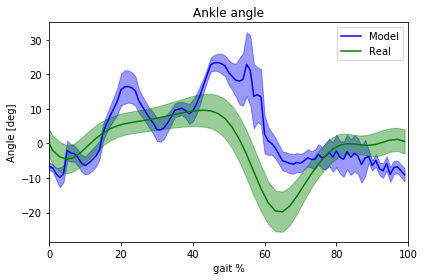

In [68]:


what="ankle"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")

ax=mean_std_fill(mean_exp,std_exp,'b')
mean_std_fill(mean_win,std_win,'g',ax)
plt.title("Ankle angle")
plt.xlabel("gait %")
plt.ylabel("Angle [deg]")
plt.legend(["Model","Real"])
plt.xlim([0,100])
plt.tight_layout()
plt.savefig("ankle_ang.png",dpi=300,transparent=True)

/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)


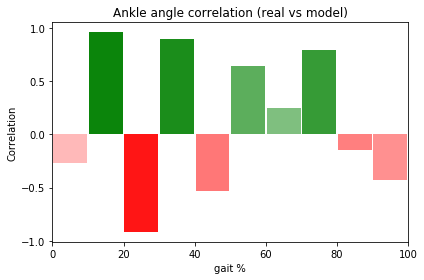

In [69]:
what="ankle"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")


df_in=pd.DataFrame()
df_in["th"]=mean_win
df_in["exp"]=mean_exp
plt.xlim([0,100])
nwind=10
wind_size=int(len(df_in)/nwind)
corr_df=pd.DataFrame(index=pd.RangeIndex(nwind),columns=["prcent","corre"])

for wind in range(nwind):
    start=wind*wind_size
    stop=(wind+1)*wind_size
    r=df_in.th[start:stop].corr(df_in.exp[start:stop])
    corr_df.corre.loc[wind]=r
    corr_df.prcent.loc[wind]=(start+stop)/2
    if r<0:
        c='r'
    else:
        c='g'
    a=abs(r)
    if a<0.25:
        a=0.5
    plt.bar((start+stop)/2,r,wind_size*0.95,color=c,alpha=a)
#sns.palplot(sns.color_palette("coolwarm", 7))
#lt.bar(x="prcent",y="corre",data=corr_df)#,palette='coolwarm')
#plt.xticks(np.linspace(0,100,20));
plt.yticks(np.linspace(-1.0,1.0,5))
plt.xlabel("gait %")
plt.ylabel("Correlation")
plt.title("Ankle angle correlation (real vs model)")
plt.tight_layout()
plt.savefig("ankle_corr.png",dpi=300,transparent=True)

> ankle oscillations during swing 70-100 gait %(causes sometime the model to fall if the ankle touches the ground )

/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)


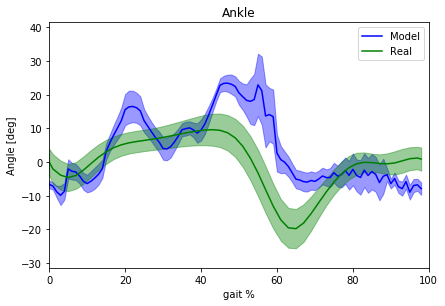

In [97]:
what="ankle"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")

save_anim(mean_win,std_win,mean_exp,std_exp,"Ankle");

/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)


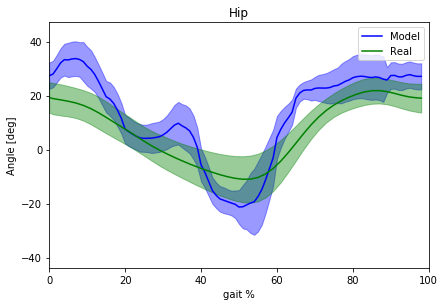

In [96]:
what="hip"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")

save_anim(mean_win,std_win,mean_exp,std_exp,"Hip");

/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)


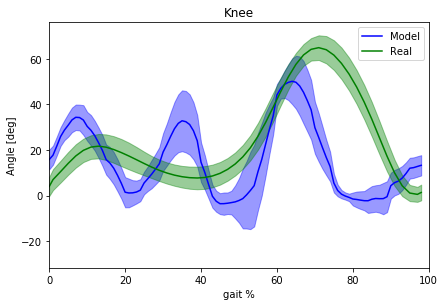

In [95]:
what="knee"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")

save_anim(mean_win,std_win,mean_exp,std_exp,"Knee");

In [94]:
from matplotlib.animation import FuncAnimation
def save_anim(mean_win,std_win,mean_exp,std_exp,name):
    fig, ax = plt.subplots()
    fig.patch.set_alpha(0.)
    max_y=max(max(mean_exp+2*std_exp),max(mean_win+2*std_win))
    min_y=min(min(mean_exp-2*std_exp),min(mean_win-2*std_win))
    plt.tight_layout()
    def update(i):
        plt.cla()
        mean_std_fill(mean_exp,std_exp,'b',ax,ratio=i/100.)
        mean_std_fill(mean_win,std_win,'g',ax,ratio=i/100.)
        plt.title(name)
        plt.xlabel("gait %")
        plt.xlim([0,100])
        plt.ylim([min_y,max_y])

        plt.ylabel("Angle [deg]")
        plt.legend(["Model","Real"])
        return ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, 100), interval=121)
    anim.save(name+".mp4", codec="png",
         dpi=100, bitrate=-1, 
         savefig_kwargs={'transparent': True, 'facecolor': 'none'})

/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/data/prevel/miniconda3/envs/bio/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)


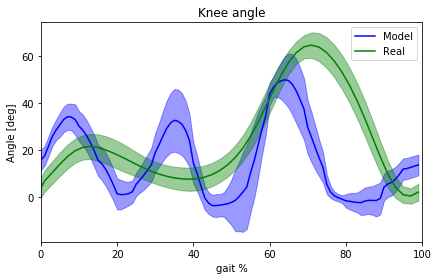

In [92]:
what="knee"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")

ax=mean_std_fill(mean_exp,std_exp,'b')
mean_std_fill(mean_win,std_win,'g',ax)
plt.title("Knee angle")
plt.xlabel("gait %")
plt.xlim([0,100])
plt.tight_layout()
plt.ylabel("Angle [deg]")
plt.legend(["Model","Real"])
plt.savefig("knee_ang.png",dpi=300,transparent=True)

> Second spike may be caused by an unnatural backlash observed at the end of the stance

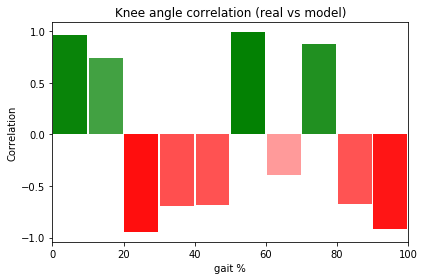

In [71]:
what="knee"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")


df_in=pd.DataFrame()
df_in["th"]=mean_win
df_in["exp"]=mean_exp
plt.xlim([0,100])
nwind=10
wind_size=int(len(df_in)/nwind)
corr_df=pd.DataFrame(index=pd.RangeIndex(nwind),columns=["prcent","corre"])

for wind in range(nwind):
    start=wind*wind_size
    stop=(wind+1)*wind_size
    r=df_in.th[start:stop].corr(df_in.exp[start:stop])
    corr_df.corre.loc[wind]=r
    corr_df.prcent.loc[wind]=(start+stop)/2
    if r<0:
        c='r'
    else:
        c='g'
    a=abs(r)
    if a<0.25:
        a=0.5
    plt.bar((start+stop)/2,r,wind_size*0.95,color=c,alpha=a)
#sns.palplot(sns.color_palette("coolwarm", 7))
#lt.bar(x="prcent",y="corre",data=corr_df)#,palette='coolwarm')
#plt.xticks(np.linspace(0,100,20));
plt.yticks(np.linspace(-1.0,1.0,5))
plt.xlabel("gait %")
plt.ylabel("Correlation")
plt.title("Knee angle correlation (real vs model)")
plt.tight_layout()
plt.savefig("knee_corr.png",dpi=300,transparent=True)

/home/prevel/.local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


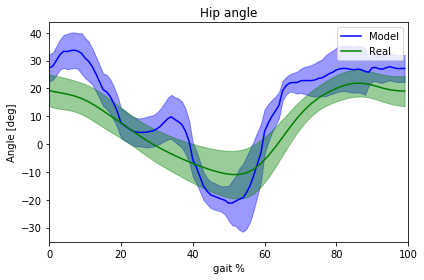

In [73]:
what="hip"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")
#ax=plt.subplot(2,1,1)
plt.xlim([0,100])
ax=mean_std_fill(mean_exp,std_exp,'b')
mean_std_fill(mean_win,std_win,'g',ax)
plt.title("Hip angle")
plt.xlabel("gait %")
plt.ylabel("Angle [deg]")
plt.tight_layout()
plt.legend(["Model","Real"])
plt.savefig("hip_ang.png",dpi=300,transparent=True)

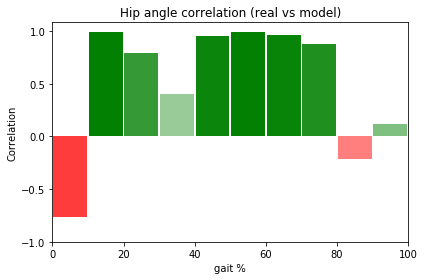

In [74]:
what="hip"
mean_win=interp_gaitprcent(win_df_data[what],100)
std_win=interp_gaitprcent(win_df_std[what],100)

mean_exp,std_exp=get_mean_std_stride(df,"angles_"+what+"_r",interp=True,stride_choice="stride24")
df_in=pd.DataFrame()
df_in["th"]=mean_win
df_in["exp"]=mean_exp
plt.xlim([0,100])
nwind=10
wind_size=int(len(df_in)/nwind)
corr_df=pd.DataFrame(index=pd.RangeIndex(nwind),columns=["prcent","corre"])

for wind in range(nwind):
    start=wind*wind_size
    stop=(wind+1)*wind_size
    r=df_in.th[start:stop].corr(df_in.exp[start:stop])
    corr_df.corre.loc[wind]=r
    corr_df.prcent.loc[wind]=(start+stop)/2
    if r<0:
        c='r'
    else:
        c='g'
    a=abs(r)
    if a<0.25:
        a=0.5
    plt.bar((start+stop)/2,r,wind_size*0.95,color=c,alpha=a)
#sns.palplot(sns.color_palette("coolwarm", 7))
#lt.bar(x="prcent",y="corre",data=corr_df)#,palette='coolwarm')
#plt.xticks(np.linspace(0,100,20));
plt.yticks(np.linspace(-1.0,1.0,5))
plt.xlabel("gait %")
plt.ylabel("Correlation")
plt.title("Hip angle correlation (real vs model)")
plt.tight_layout()
plt.savefig("hip_corr.png",dpi=300,transparent=True)

> Really ugly

### TODO
- fix color to depend on correlation value


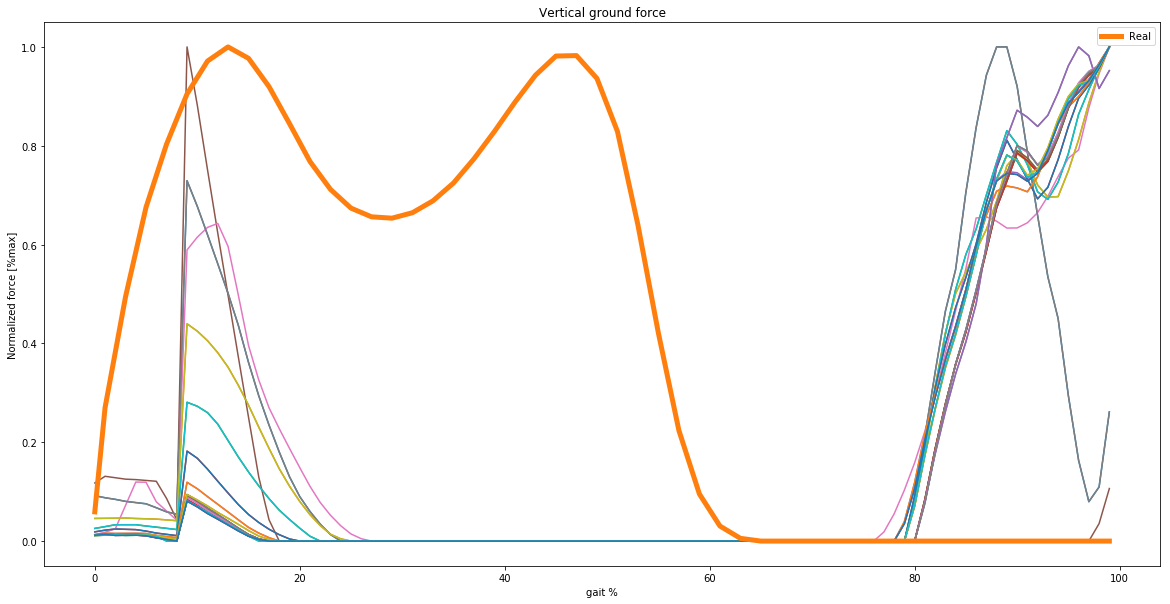

In [15]:
plt.figure(figsize=(20,10))

all_fy=get_all_stride(df,"LGRF_GRFy",how="strike_to_liftoff",interp=True)
sm=all_fy.rolling(10).sum()
sm=sm.fillna(all_fy)
#mean_exp=all_fy.mean(axis=1)
#plt.plot(mean_exp/mean_exp.max());
plt.plot(sm/sm.max(axis=0))

th=interp_gaitprcent(win_df_data.fy,100)
plt.plot(th/th.max(),label='Real',linewidth=5)

plt.legend()
plt.title("Vertical ground force")
plt.xlabel("gait %")
plt.ylabel("Normalized force [%max]");


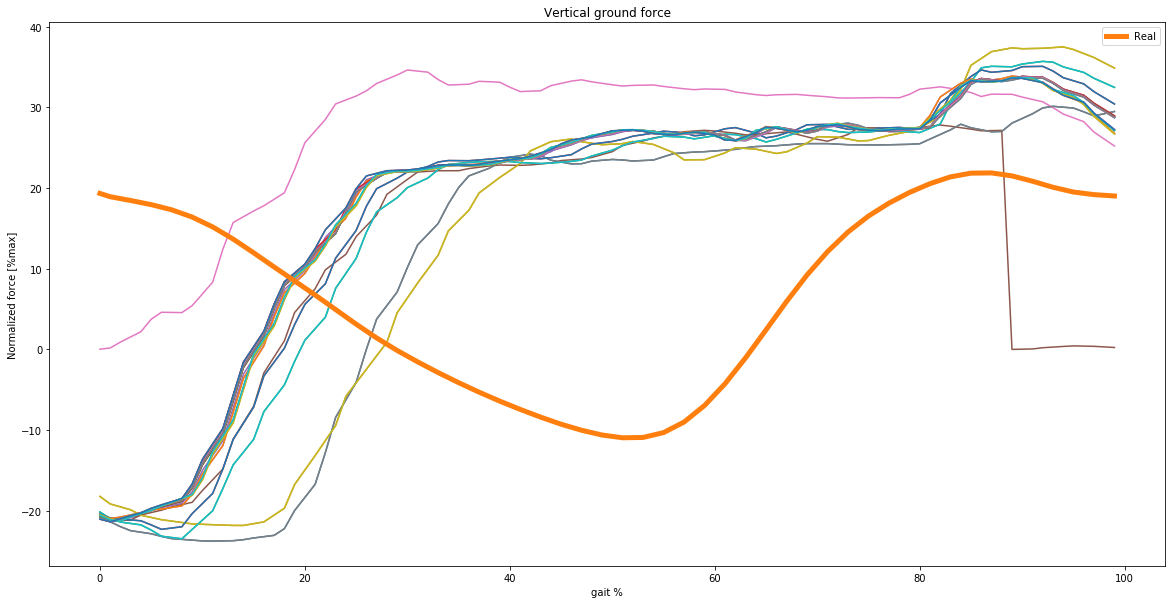

In [16]:
plt.figure(figsize=(20,10))

all_fy=get_all_stride(df,"angles_hip_l",how="strike_to_liftoff",interp=True)
mean_exp=all_fy.mean(axis=1)
plt.plot(all_fy*180/np.pi);

th=interp_gaitprcent(win_df_data.hip,100)
plt.plot(th,label="Real",linewidth=5)

plt.legend()
plt.title("Vertical ground force")
plt.xlabel("gait %")
plt.ylabel("Normalized force [%max]");

stride0 7.0 10.8
stride1 14.2 17.25
stride2 19.7 23.3
stride3 25.7 29.3
stride4 31.6 35.35
stride5 37.55 41.25
stride6 43.5 47.2
stride7 49.45 53.15
stride8 55.4 59.1
stride9 61.35 65.05
stride10 67.3 71.0
stride11 73.2 77.0
stride12 79.15 82.95
stride13 85.15 88.9
stride14 91.1 94.85
stride15 97.05 100.35
stride16 100.35 103.95
stride17 107.0 110.8
stride18 114.2 117.25
stride19 119.7 123.3
stride20 125.7 129.3
stride21 131.6 135.35
stride22 137.55 141.25
stride23 143.5 147.2
stride24 149.45 153.15
stride25 155.4 159.1
stride26 161.35 165.05
stride27 167.3 171.0
stride28 173.2 177.0
stride29 179.15 182.95
stride30 185.15 188.9


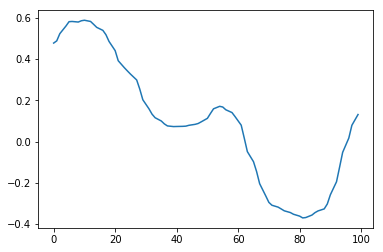

In [17]:
all_fy,ts=get_all_stride(df,"angles_hip_r",how="strike_to_liftoff",interp=True,with_timestamps=True)
for stride,stamps in ts.items():
    print(stride,stamps[0]/20.,stamps[1]/20.)
plt.plot(all_fy["stride24"])

## Improved event detection (start of ground contact instad of max value)

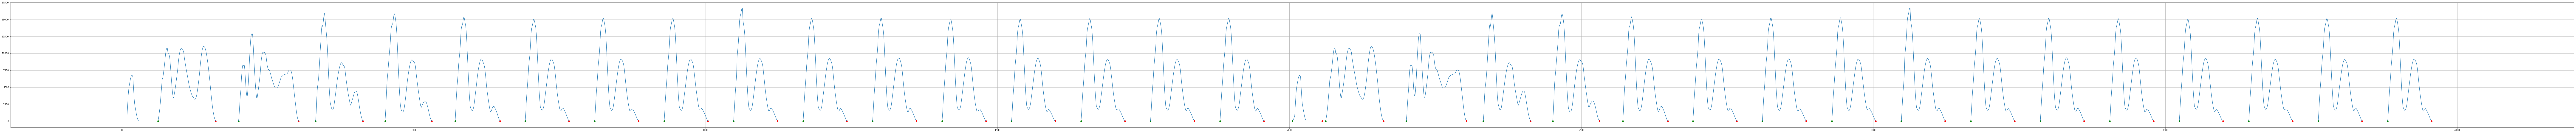

In [18]:
plt.figure(figsize=(200,10))
r=add_strike_lift(df)
plt.plot(r.left)
plt.scatter(r.index, r['l_lift'], c='r',label="lift")
plt.scatter(r.index, r['l_strike'], c='g',label="strike")
plt.grid(which='both')